<a href="https://colab.research.google.com/github/yagel2/TDS_NYC_Airbnb/blob/main/TDS_Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TDS Assignment 2: Advanced Model Analysis, Optimization and Conclusions**
### **Course:** Tabular Data Science Exercise 2
### **Author:** Yagel Alankry and Ido Keren


Load imports and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

!wget  --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/AB_NYC_2019.csv

df = pd.read_csv('AB_NYC_2019.csv')

File ‘AB_NYC_2019.csv’ already there; not retrieving.



**Recall: our regression model was the following**

Data preprocessing:

In [2]:
# Fill missing values in 'reviews_per_month' by reassigning the column directly
olddataset = df.copy()
olddataset['reviews_per_month'] = olddataset['reviews_per_month'].fillna(0)

# Drop rows with missing values in the 'price' column
olddataset = olddataset.dropna(subset=['price'])

# One-hot encoding
olddataset = pd.get_dummies(olddataset, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Feature matrix (X) and target vector (y)
X = olddataset[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
        'availability_365', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens',
        'room_type_Private room', 'room_type_Shared room']]
y = olddataset['price']

Split the data:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the model:

In [4]:
xgb_model = XGBRegressor()

# Train and make predictions
y_pred = xgb_model.fit(X_train, y_train).predict(X_test)
y_train_pred = xgb_model.fit(X_train, y_train).predict(X_train)

Plot the result:

<Axes: title={'center': 'Predicted vs. Actual Prices'}, xlabel='Predicted Price ($)', ylabel='Actual Price ($)'>

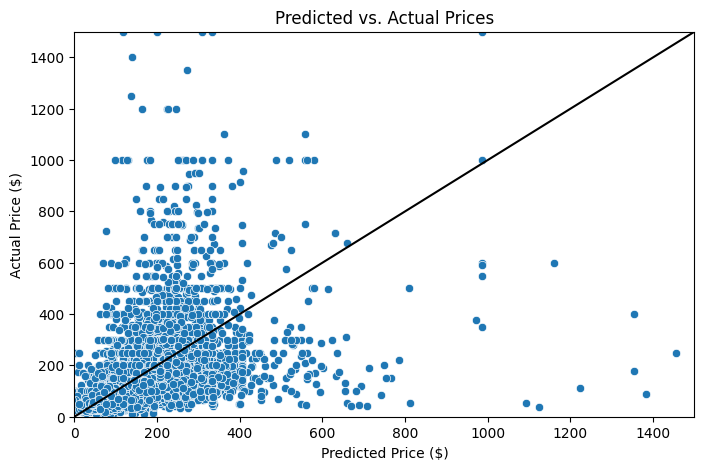

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax)
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Actual Price ($)')
plt.ylim(0, 1500)
plt.xlim(0, 1500)
ax.set_title('Predicted vs. Actual Prices')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='black')

**1. Error Analysis Conclution and Work Plan.**

The first obvious tests we have made are the mean absolute error, mean squared error and r^2 score.

In [6]:
maeold = mean_absolute_error(y_test, y_pred)
mseold = mean_squared_error(y_test, y_pred)
r2old = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {maeold}")
print(f"Mean Squared Error (MSE): {mseold}")
print(f"R² Score: {r2old}")

Mean Absolute Error (MAE): 71.35013580322266
Mean Squared Error (MSE): 48278.375
R² Score: -0.09132671356201172


We saw our results were very bad, the negative r^2 score reveals it would have been better to use the average price to predict, our guess is the model is overfitting. to check we will test the same on our training set:

In [7]:
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 64.36627960205078
Mean Squared Error (MSE): 34114.3515625
R² Score: 0.4409882426261902


We see our model does work significantly better on our training set so it's safe to conclude our model does overfit.

Next, we evaluated our features importance in the model. and saw availability_365, room_type_private room and neighbourhood_group_Blooklyn being the most influential:

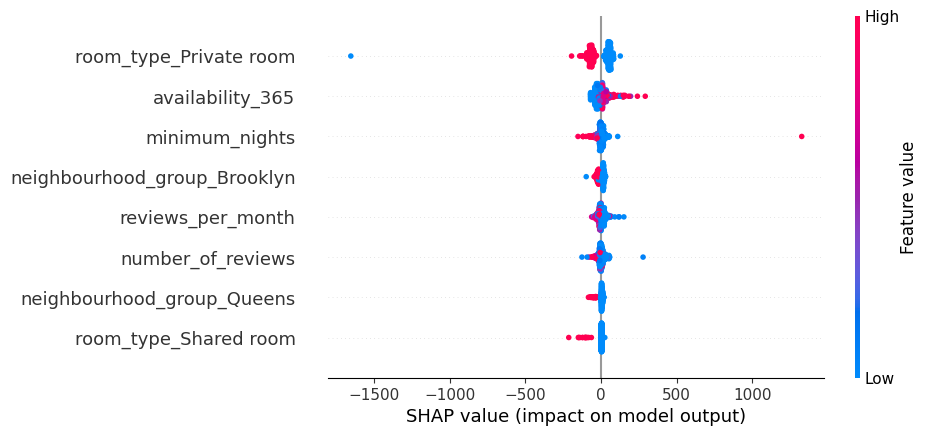

In [8]:
# Get a sample of values
shap_sample = X_train.sample(500)

# Create an explainer using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the training data (or you can use X_test)
shap_values = explainer(shap_sample)

# Plot summary of SHAP values for the features
shap.plots.beeswarm(shap_values)

This gives us an idea on what feature should and shouldn't be on our model, a look into the relation between price and other featutes could strenthan this claim

<Axes: >

<Figure size 1200x800 with 0 Axes>

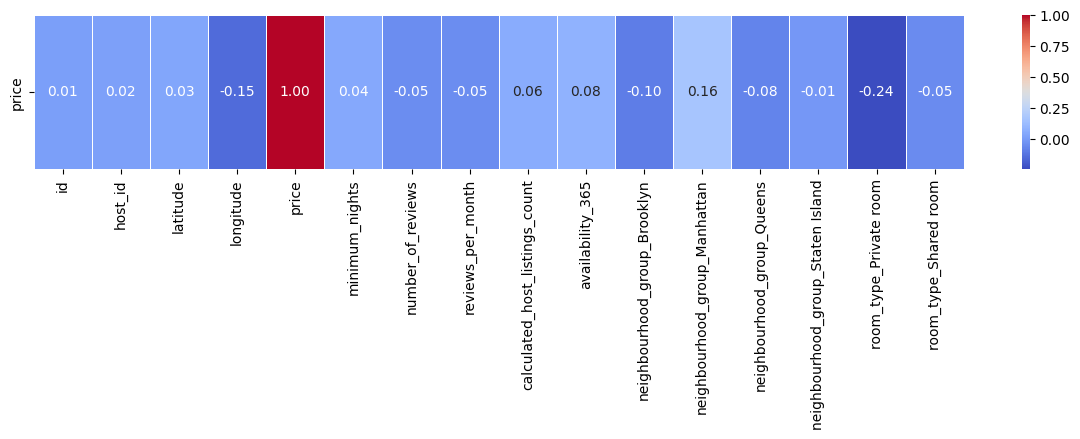

In [9]:
plt.figure(figsize=(12, 8))

olddataset = olddataset.select_dtypes(include=['number', 'bool'])  # Select only numeric columns


dataset_corr = olddataset.corr(method="pearson").loc[["price"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dataset_corr, annot=True, fmt='.2f', cmap="coolwarm", cbar=True, linewidths=0.5,ax=ax)

We see not only brooklyn is an important feature but all location based features have releavance. also shared room really does tell a lot less than private room like we expected.

Our work plan: deal with the overfitting, focus on the more important features both by shap value and by correlation with price.

**2. Improving Model Performance**

In [10]:
# Fill missing values in 'reviews_per_month' by reassigning the column directly
dataset = df.copy()

# Drop rows with missing values in the 'price' column
dataset = dataset.dropna(subset=['price'])

# One-hot encoding
dataset = pd.get_dummies(dataset, columns=['room_type'], drop_first=True)

HyperParameter Tuning- we saw that the model overfit, to dal with that we will limit the maximum depth allowed in the decision tree to 2.

In [11]:
xgb_model = XGBRegressor(max_depth=2)

Feature Engineering- we saw our shap result as well as the correlation between price and the other features.

Our first observation was about the importance of the location when its manhatten or brooklyn, yet less important for other neighbourhoods. this could be because those neighbourhoods our closer to times square- the city center. instead of using the neighbourhood we will calculate a feature for distance from the city center.

In [12]:
# Define the city center coordinates (Times Square)
city_center_lat = 40.7580
city_center_lon = -73.9855

# Calculate Euclidean distance to the city center
dataset['distance_to_center'] = np.sqrt(
    (dataset['latitude'] - city_center_lat)**2 + (dataset['longitude'] - city_center_lon)**2
)

Next, we will try to create a more significant feature from each feate on its own. we will calculate how many days an airbnb was available but rather then per year we will count the total days. we will do this by calculating how many months the airbnb was for sale, and we will calculate this using the reviews per month and total reviews features.

In [13]:
dataset['months_for_sale'] = (dataset['reviews_per_month'] / dataset['number_of_reviews'])
dataset['availability_ever'] = (dataset['availability_365'] / 12 * dataset['months_for_sale'])

Lastly, we will remove features thatwere deemed not important enough for our model or without enough correlation. those are number_of_reviews, minimum_nights, and the neighbourhood group. and add our new features we created.

In [14]:
X = dataset[['availability_365', 'availability_ever', 'reviews_per_month',
             'room_type_Private room', 'room_type_Shared room', 'distance_to_center']]

y = dataset['price']

Handling missing data- first we will check whay data is missing.

In [15]:
X.isna().sum()

,0
availability_365,0
availability_ever,10052
reviews_per_month,10052
room_type_Private room,0
room_type_Shared room,0
distance_to_center,0


The review per month and availability ever are missing, we will fill them with the mean.

In [16]:
dataset['availability_ever'] = dataset['availability_ever'].fillna(dataset['availability_ever'].mean())
dataset['reviews_per_month'] = dataset['reviews_per_month'].fillna(dataset['reviews_per_month'].mean())

**The Updated Model**

Split the data:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the model:

In [18]:
# Train and make predictions
y_pred = xgb_model.fit(X_train, y_train).predict(X_test)
y_train_pred = xgb_model.fit(X_train, y_train).predict(X_train)

Plot the result:

<Axes: title={'center': 'Predicted vs. Actual Prices'}, xlabel='Predicted Price ($)', ylabel='Actual Price ($)'>

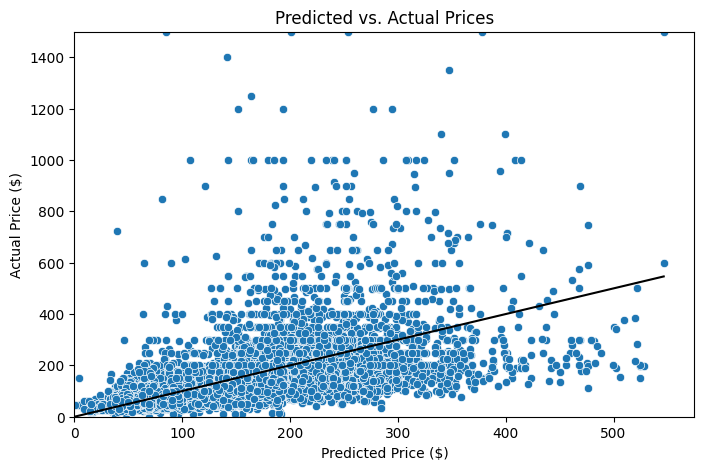

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax)
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Actual Price ($)')
plt.ylim(0, 1500)
plt.xlim(0, 575)
ax.set_title('Predicted vs. Actual Prices')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='black')

**3. Analyzing the Improved Model**

the mean absolute error, mean squared error and r^2 score.

In [20]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 66.39801788330078
Mean Squared Error (MSE): 37935.890625
R² Score: 0.14246386289596558


to make sure there is no ovefitting, testing the same on the training set.

In [21]:
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 70.74036407470703
Mean Squared Error (MSE): 53179.29296875
R² Score: 0.12858235836029053


There is no overfitting now, which is good. also it's clear to see the improvement from the previous model:

In [22]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae} for the new model, {maeold} for the old model")
print(f"Mean Squared Error (MSE): {mse} for the new model, {mseold} for the old model")
print(f"R² Score: {r2} for the new model, {r2old} for the old model")

Mean Absolute Error (MAE): 66.39801788330078 for the new model, 71.35013580322266 for the old model
Mean Squared Error (MSE): 37935.890625 for the new model, 48278.375 for the old model
R² Score: 0.14246386289596558 for the new model, -0.09132671356201172 for the old model


The importance of each of our features by using shap

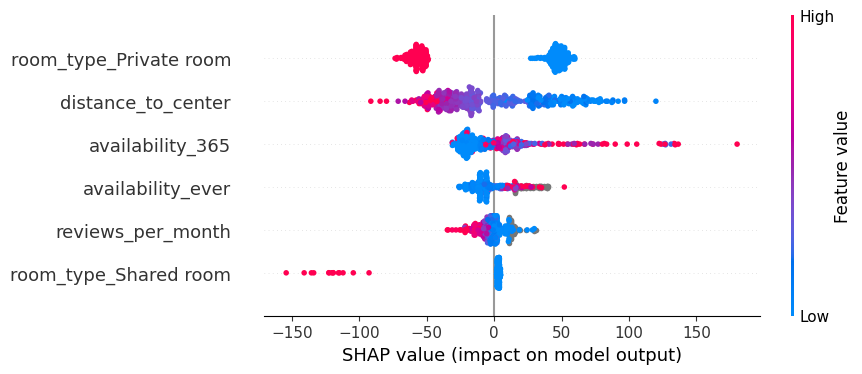

In [23]:
# Get a sample of values
shap_sample = X_train.sample(500)

# Create an explainer using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the training data (or you can use X_test)
shap_values = explainer(shap_sample)

# Plot summary of SHAP values for the features
shap.plots.beeswarm(shap_values)